# Description

This notebook makes use of the **pandas** library and the **ete3 toolkit**, specifically ete3's [NCBI Taxonomic database](http://etetoolkit.org/docs/latest/tutorial/tutorial_ncbitaxonomy.html). Several custom functions simplifying the use of ete3 are in the zoonosis_helper_functions.py script which is imported into the notebook.


The primary data is obtained from the Uniprot database. It contains data on proteins which facilitate viral [entry into host cells](https://www.uniprot.org/uniprot/?query=keyword:%22Virus%20entry%20into%20host%20cell%20[KW-1160]%22). The data is in 2 parts, the first being the [tabular data](#tabular-data) and the second being the [fasta sequences](#fasta) of the virus surface proteins. The 2 are linked by their uniprot entry identifiers. A very small portion of the data has been reviewed and is not sufficient for application in deep learning so both the reviewed and unreviewed data is kept, however, the unreviewed data lacks information on host data.

To alleviate the host data information, external sources were used, namely:

- [NCBI Virus database](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?VirusLineage_ss=Viruses,%20taxid:10239&SeqType_s=Protein&Proviral_s=exclude&HostLineage_ss=Mammalia%20(mammals),%20taxid:40674)
- [Virus-Host database](https://www.genome.jp/virushostdb/)
- [Enhanced Infectious Disease Database (EID2)](https://eid2.liverpool.ac.uk/OrganismInteractions)

1. [The ete3 is first used to obtain taxomomic identifiers at the species level and if an identifier is already present to still use the ete3 taxonomic identifiers for consistency.](#ete3-taxo)

1. [Data is further filtered to keep only viruses (organism).](#filter)

1. [The dataset contains some repetitive information i.e. same virus, same hosts but different protein or different protein entry. Therefore, the next step was to fill in the host data using information from the reviewed data. The premise was if it's the same virus then it ought to have the same hosts.](#Updating-host-names-from-other-host-data-in-the-dataset)

1. [Thereafter information form external sources is appended to the primary data. Missing data after final processing is dropped.](#Updating-host-names-from-external-sources)

1. [An additional column (Infects human) is then later added. If at least one of the virus hosts is homo sapiens then an assignment of **1** is given otherwise **0** is assigned to the row.](#Further-Processing)

1. [Since the data was obtained from multiple sources further processing was done to make the information format consistent.](#host-name-consistency)

1. [The sequence data is loaded and linked to the tabular data.](#fasta)

1. [Protein names are also updated from sequence data for consistency in the data.](#protein-names-from-sequence)

1. [After processing, the data is then split into training and testing data. Validation split is done upon loading the training data with **keras**.](#splits)

1. [random undersampling](#Random-Undersampling-of-datasets)

1. [Write file sequences to fasta for feature extraction](#Write-file-sequences-to-fasta-for-feature-extraction)


<!-- ### [Absolutely no idea why Virus host name != Virus hosts](#issue) -->

## Packages

In [1]:
# Import all necesssary modules
## Always import pandas before swifter ##
import pandas as pd
import swifter # enables pandas multiprocessing using modin and ray as a backend. Also adds progress bar functionality
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import re
import os
from ete3 import NCBITaxa # Takes a while on first time load
from pprint import pprint
from tqdm.notebook import tqdm_notebook, tqdm
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
from zoonosis_helper_functions import * # in the current directory

In [2]:
# Configure Progress bar and Modin Pandas Engine

tqdm.pandas(desc='Processing')
os.environ["MODIN_ENGINE"] = "ray"

## Data exploration

<a id='tabular-data'></a>

In [3]:
# Load dataset downloaded from Uniprot
df = pd.read_table('../data/uniprot-keyword Virus+entry+into+host+cell+[KW-1160] +fragment no.tab.gz')

In [4]:
df.shape

(358333, 9)

In [5]:
df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
329099,E9JT84,E9JT84_9HIV1,unreviewed,Envelope glycoprotein gp160 (Env polyprotein) ...,Human immunodeficiency virus 1,838,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606]
331553,A0A3G5PFY0,A0A3G5PFY0_9HIV1,unreviewed,Envelope glycoprotein gp160 (Env polyprotein) ...,Human immunodeficiency virus 1,871,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606]
220345,I3QSN6,I3QSN6_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/Scotland/EastKilbride_420...,566,1140188,Influenza A virus,NaN


In [6]:
title_params = {'fontsize': 17,
                'fontweight': 'bold'}

[Matplotlib font stuff](https://matplotlib.org/stable/tutorials/text/text_props.html)

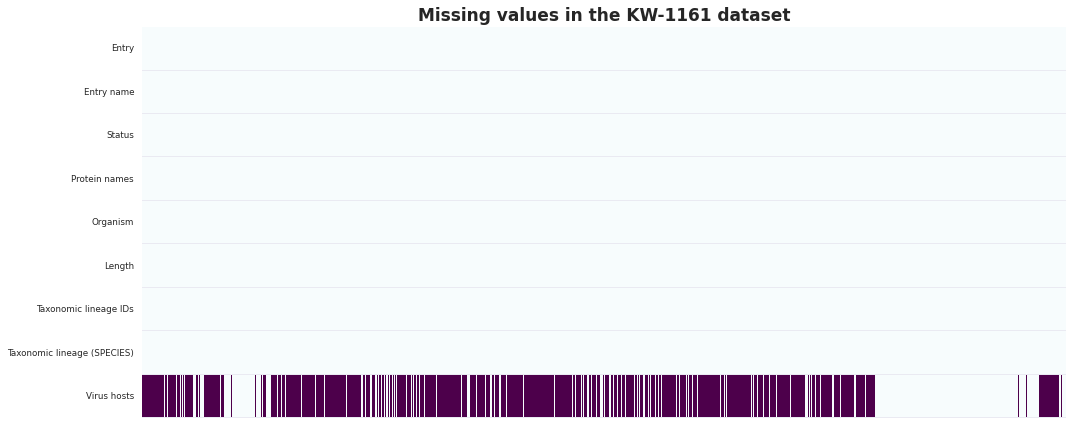

In [7]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df.copy().T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

ax.set_title("Missing values in the KW-1161 dataset", fontdict=title_params)

plt.tight_layout()
plt.savefig("Missing_hosts_heatmap.png")

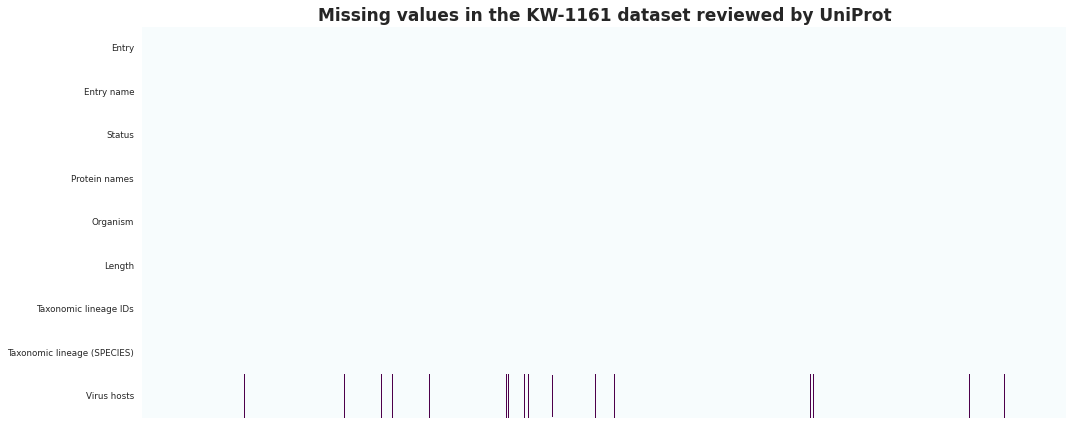

In [8]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df[df["Status"] == "reviewed"].T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

ax.set_title("Missing values in the KW-1161 dataset reviewed by UniProt", fontdict=title_params)

plt.tight_layout()
plt.savefig("Reviewed_missing_hosts_heatmap.png")

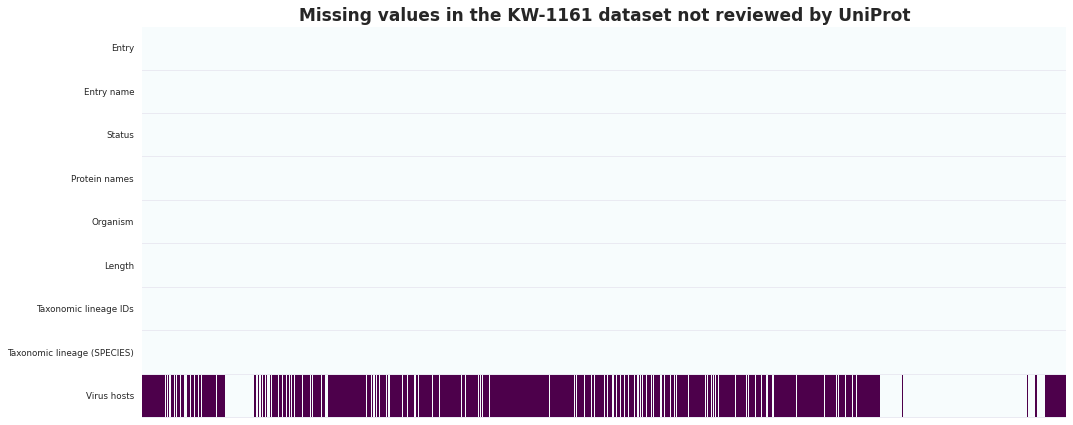

In [9]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df[df["Status"] == "unreviewed"].T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

ax.set_title("Missing values in the KW-1161 dataset not reviewed by UniProt", fontdict=title_params)

plt.tight_layout()
plt.savefig("Unreviewed_missing_hosts_heatmap.png")

In [10]:
# Check for number of rows with missing host names
print(df[df['Virus hosts'].isnull()].shape)
df[df['Virus hosts'].isnull()].sample(3)

(237573, 9)


,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
64222,A0A126UAP4,A0A126UAP4_9INFB,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza B virus (B/Brisbane/5/2014),560,1757434,Influenza B virus,NaN
189406,A0A193AT19,A0A193AT19_9INFA,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza A virus (A/Illinois/08/2016(H3N2)),498,1865885,Influenza A virus,NaN
186147,A0A2H4TBR5,A0A2H4TBR5_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/mallard duck/Ohio/16OS082...,562,2050525,Influenza A virus,NaN


In [11]:
# Total number of different organisms in dataset (inclusive of reviewed and non-reviewed)
df['Organism'].nunique()

100216

In [12]:
# Total number of different organisms with reviewed data
df[df['Status'] == 'reviewed']['Organism'].nunique()

1518

In [13]:
df[df['Status'] == 'unreviewed']['Organism'].nunique()

99095

In [14]:
# Check for number of rows with reviewed hosts
df[df['Status'] == 'reviewed']['Virus hosts'].nunique()

321

In [15]:
df[df['Status'] == 'unreviewed']['Virus hosts'].nunique()

200

In [16]:
# Total number of rows with host information (inclusive of reviewed and non-reviewed)
df['Virus hosts'].nunique()

373

In [17]:
# Checking if there is no missing organism taxonomy data. Organism == Tax IDs
df['Taxonomic lineage IDs'].nunique()

100216

In [18]:
def variable_value_heatmap(df, variable: str):
    overview = df.copy().melt(id_vars=['Entry'], value_vars=[variable])
    crosstab_overview = pd.crosstab(overview['variable'], overview['value'])
    ax = sns.barplot(data=df)
    return crosstab_overview.head()

value,reviewed,unreviewed
variable,,
Status,2426,355907


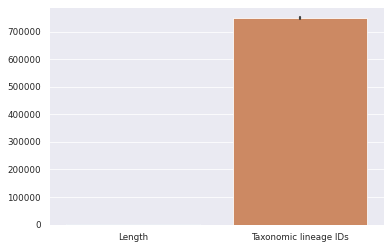

In [19]:
variable_value_heatmap(df, "Status")

In [20]:
overview = df.copy().melt(id_vars=['Entry'], value_vars=["Status"])
crosstab_overview = pd.crosstab(overview['variable'], overview['value'])

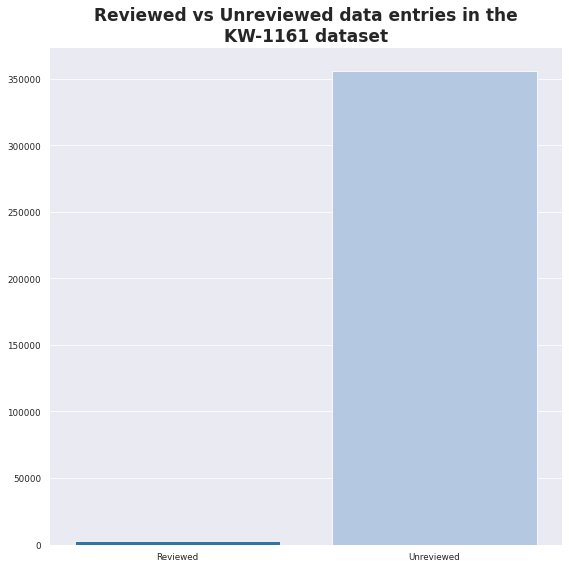

In [21]:
plt.figure(figsize=(8,8))
sns.set_theme(context="paper", style="darkgrid", palette="tab20")

ax = sns.barplot(data=crosstab_overview)

ax.set_title("Reviewed vs Unreviewed data entries in the\nKW-1161 dataset", fontdict=title_params)

ax.set_xticklabels(["Reviewed", "Unreviewed"])
ax.set_xlabel("")

plt.tight_layout()
plt.savefig("Reviewed_unreviewed_barplot.png")

In [22]:
label_text_params = {'fontsize': 'x-small'}

In [23]:
# overview = pd.pivot_table(df, values=["Protein names", "Virus hosts"],
#                           index="Taxonomic lineage (SPECIES)", fill_value="",
#                           # columns=,
#                           aggfunc={"Protein names":lambda x: len(set(x)), "Virus hosts":lambda x: len(set(x))})

# overview.sample(10)

# plt.figure(figsize=(15,40))

# ax = sns.heatmap(overview, cmap="Blues", vmin=0, vmax=5,
#             # cbar=False, annot=True,
#             # xticklabels=False, yticklabels=False,
#                 )
# ax.set_title("Overview of number of proteins and host groups per virus species", fontdict=title_params)
# ax.set_ylabel('')
# ax.set_xticklabels(['Proteins', 'Hosts'])
# ax.set_yticklabels(ax.get_yticklabels(), fontdict=label_text_params)

# plt.tight_layout()
# plt.savefig("Species_prot_host.png")

In [24]:
df['Length'] = df['Length'].apply(int)

In [25]:
data_sample = df.sample(8000)

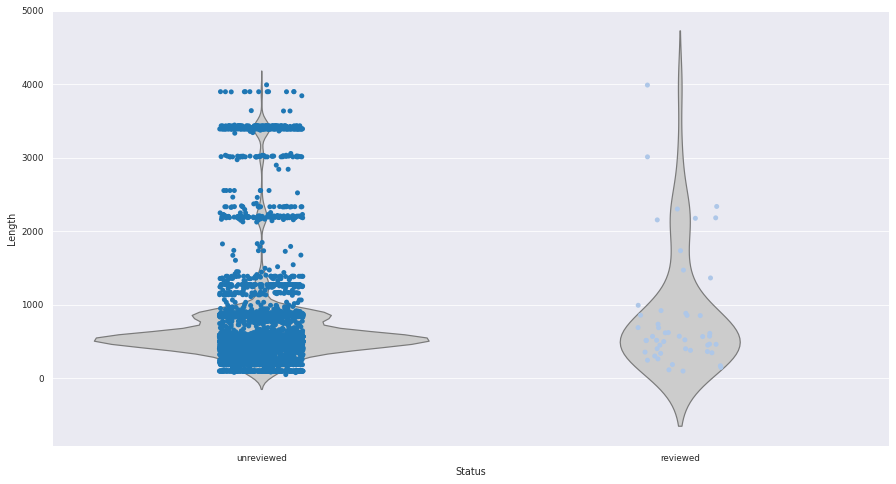

In [26]:
plt.figure(figsize=(15, 8))
sns.set_theme(context="paper", style="darkgrid", palette="tab20")


ax = sns.violinplot(x="Status", y="Length", data=data_sample,
                    inner=None, color=".8")

ax = sns.stripplot(x="Status", y="Length", data=data_sample)

In [27]:
# plt.figure(figsize=(16, 8))
# sns.set_theme(style="darkgrid")

# ax = sns.swarmplot(x="Status", y="Length", data=data_sample)

# ax.set_title("Distribution of protein sequence lengths sample", fontdict=title_params)
# ax.set_ylabel('Protein sequence length')
# ax.set_xticklabels(['Unreviewed', 'Reviewed'])
# # ax.set_yticklabels(ax.get_yticklabels(), fontdict=label_text_params)

# plt.tight_layout()

# # plt.savefig("Dist_protein_length.png")

## Initial processing

In [28]:
df_full_record_tracking = dict()
df_full_record_tracking.update({"Preprocessed": df.shape[0]})

In [29]:
## Replace N/A columns with an empty string... prevents errors with column wide string operations
df['Virus hosts'] = np.where(df['Virus hosts'].isnull(), '', df['Virus hosts'])

In [30]:
df.sample(5)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
299159,A0A1P8P559,A0A1P8P559_9HIV1,unreviewed,Envelope glycoprotein gp160 (Env polyprotein) ...,Human immunodeficiency virus 1,869,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606]
182974,D8V9J0,D8V9J0_HBV,unreviewed,Large envelope protein (L glycoprotein) (L-HBs...,Hepatitis B virus (HBV),400,10407,Hepatitis B virus (HBV),Homo sapiens (Human) [TaxID: 9606]; Pan troglo...
327831,H9BXC0,H9BXC0_SIV,unreviewed,Envelope glycoprotein gp160 [Cleaved into: Sur...,Simian immunodeficiency virus (SIV),881,11723,Simian immunodeficiency virus (SIV),Cercopithecidae (Old World monkeys) [TaxID: 95...
283167,A0A1S6K4W6,A0A1S6K4W6_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/Arizona/82/2016(H1N1)),566,1961925,Influenza A virus,
305498,A0A0K0UU44,A0A0K0UU44_9HIV1,unreviewed,Envelope glycoprotein gp160 (Env polyprotein) ...,Human immunodeficiency virus 1,857,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606]


In [31]:
def join_names(df, col_name: str):
    df[col_name] = df[col_name].str.split('; ').apply(set).apply('; '.join) # 'set' function removes duplicate entries
    return df

In [32]:
# df['Virus hosts'] = df['Virus hosts'].str.split('; ')
# df['Virus hosts'] = df['Virus hosts'].swifter.progress_bar(enable=True, desc='Removing duplicate host names').apply(set)
# df['Virus hosts'] = df['Virus hosts'].swifter.progress_bar(enable=True, desc='Joining host names list').apply('; '.join)

# df['Protein names'] = df['Protein names'].str.split('; ')
# df['Protein names'] = df['Protein names'].swifter.progress_bar(enable=True, desc='Removing duplicate protein names').apply(set)
# df['Protein names'] = df['Protein names'].swifter.progress_bar(enable=True, desc='Joining protein names list').apply('; '.join)

# df['Organism'] = df['Organism'].str.split('; ')
# df['Organism'] = df['Organism'].swifter.progress_bar(enable=True, desc='Removing duplicate organism names').apply(set)
# df['Organism'] = df['Organism'].swifter.progress_bar(enable=True, desc='Joining organism names list').apply('; '.join)

In [33]:
# Remove duplicate entries if present
df = join_names(df, 'Virus hosts')
df = join_names(df, 'Protein names')
df = join_names(df, 'Organism')

df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
16119,B7ZFA6,B7ZFA6_9INFA,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza A virus (A/mute swan/Germany/R1359/2...,498,542768,Influenza A virus,
288176,A0A1W6I923,A0A1W6I923_9HIV1,unreviewed,Transmembrane protein gp41 (TM) (Glycoprotein ...,Human immunodeficiency virus 1,866,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606]
3270,E6WZ47,E6WZ47_NITSE,unreviewed,Integrase family protein,Nitratifractor salsuginis (strain DSM 16511 / ...,412,749222,Nitratifractor salsuginis,


<a id="ete3-taxo" ></a>

In [34]:
# Species ID from organism ID
df['Species taxonomic ID'] = (df['Taxonomic lineage IDs']
                              .swifter.progress_bar(enable=True, desc='Getting Viruses taxonomic IDs')
                              .apply(getRankID, rank='species')) # getRankID function in zoonosis_helper_functions.py

Getting Viruses taxonomic IDs:   0%|          | 0/64 [00:00<?, ?it/s]

In [35]:
# Copy for later use
dff = df[['Entry', 'Species taxonomic ID', 'Length']].copy()

In [36]:
df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID
297585,C0L103,C0L103_9HIV1,unreviewed,Transmembrane protein gp41 (TM) (Glycoprotein ...,Human immunodeficiency virus 1,857,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606],11676.0
2750,A0A376IBY0,A0A376IBY0_ECOLX,unreviewed,DUF4102 domain-containing protein (Integrase) ...,Escherichia coli,394,562,Escherichia coli,,562.0
255866,A0A126UCY1,A0A126UCY1_9INFB,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza B virus (B/Newcastle/10/2014),560,1757395,Influenza B virus,,11520.0


In [37]:
# Check if all tax IDs could be found in NCBI taxonomy database
df[df['Species taxonomic ID'].isnull()].sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID
189041,Q0NCN9,Q0NCN9_VAR65,unreviewed,IMV membrane protein,Variola virus (isolate Human/South Africa/102/...,133,587201,Variola virus,Homo sapiens (Human) [TaxID: 9606],NaN
191463,Q784K9,Q784K9_HBVF5,unreviewed,Capsid protein (Core antigen) (Core protein) (...,Hepatitis B virus genotype F2 (isolate Venezue...,183,489502,Hepatitis B virus (HBV),Homo sapiens (Human) [TaxID: 9606]; Pan troglo...,NaN
87500,B2BX77,B2BX77_ASPVR,unreviewed,Hemagglutinin-neuraminidase protein,Atlantic salmon paramyxovirus (isolate -/Norwa...,576,1283346,Salmon aquaparamyxovirus,Salmo salar (Atlantic salmon) [TaxID: 8030],NaN


In [38]:
# Get the species name of the earlier unidentified taxonomic IDs
idx_species_name = df.columns.get_loc('Taxonomic lineage (SPECIES)')
idx_organism_id = df.columns.get_loc('Species taxonomic ID')

for row in tqdm_notebook(range(len(df)), desc='Getting species ID from organism name'):
    if np.isnan(df.iat[row, idx_organism_id]):
        # getIDfromName function in zoonosis_helper_functions.py
        df.iat[row, idx_organism_id] = getIDfromName(df.iat[row, idx_species_name])

Getting species ID from organism name:   0%|          | 0/358333 [00:00<?, ?it/s]

In [39]:
df[df['Species taxonomic ID'].isnull()]

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID


In [40]:
df['Species taxonomic ID'] = df['Species taxonomic ID'].apply(int) # convert taxid from floats to int

In [41]:
df.shape

(358333, 10)

In [42]:
df = (df.drop(['Status','Taxonomic lineage IDs'], axis=1)
      .groupby('Species taxonomic ID', as_index=False)
      .agg({'Virus hosts':set, 'Organism':set,
            'Protein names':set, 'Taxonomic lineage (SPECIES)':'first'}))

In [43]:
df['Virus hosts'] = df['Virus hosts'].str.join('; ')
df['Organism'] = df['Organism'].str.join('; ')
df['Protein names'] = df['Protein names'].str.join('; ')

In [44]:
df.sample(5)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Taxonomic lineage (SPECIES)
9353,2048283,,Thalassospira marina,Integrase,Thalassospira marina
9538,2060957,,Staphylococcus phage phiSa2wa_st93mssa,Integrase; Portal protein,Staphylococcus phage phiSa2wa_st93mssa
14500,2844230,,Escherichia phage SH2026Stx1,Integrase; Putative tail fiber protein,Escherichia phage SH2026Stx1
5904,1647551,,Moraxella phage Mcat5,Portal protein,Moraxella phage Mcat5
7874,1932111,,Pseudomonas sp. PA15(2017),Integrase,Pseudomonas sp. PA15(2017)


In [45]:
df.shape

(14877, 5)

In [46]:
# Get species name from NCBI taxo database using Taxonomic ID
df['Species name'] = (df.drop('Taxonomic lineage (SPECIES)', axis=1)
                      .swifter.progress_bar(enable=True, desc='Getting Species name')
                      .apply(lambda x: getRankName(x['Species taxonomic ID'], 
                                                   rank='species'), axis=1))

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [47]:
# Get superkingdom name from NCBI taxo database using Taxonomic ID
df['Species superkingdom'] = df['Species taxonomic ID'].progress_apply(getRankName, rank='superkingdom')

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [48]:
# Get family from NCBI taxo database using Taxonomic ID
df['Species family'] = df['Species taxonomic ID'].progress_apply(getRankName, rank='family')

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [49]:
df['Species superkingdom'].nunique()

23

In [50]:
overview = pd.pivot_table(df, values=["Species name", "Species family"],
                          index="Species superkingdom", #fill_value="",
                          # columns=,
                          aggfunc={"Species name":lambda x: len(set(x)),
                                   "Species family":lambda x: len(set(x))}
                         )
overview.sort_values("Species name", ascending=False)

,Species family,Species name
Species superkingdom,,
Viruses,182,7903
Bacteria,799,6833
Eukaryota,85,115
Archaea,7,7
marine metagenome,1,1
viral metagenome,1,1
uncultured organism,1,1
uncultured marine microorganism HF4000_005I08,1,1
sediment metagenome,1,1


In [51]:
overview.reset_index(inplace=True)
overview["Species superkingdom"] = overview["Species superkingdom"].str.replace(" ", "\n")
overview

,Species superkingdom,Species family,Species name
0,Archaea,7,7
1,Bacteria,799,6833
2,Eukaryota,85,115
3,IncJ\nplasmid\nR391,1,1
4,Plasmid\npFKY1,1,1
5,Viruses,182,7903
6,anaerobic\ndigester\nmetagenome,1,1
7,biofilter\nmetagenome,1,1
8,bioreactor\nmetagenome,1,1
9,freshwater\nmetagenome,1,1


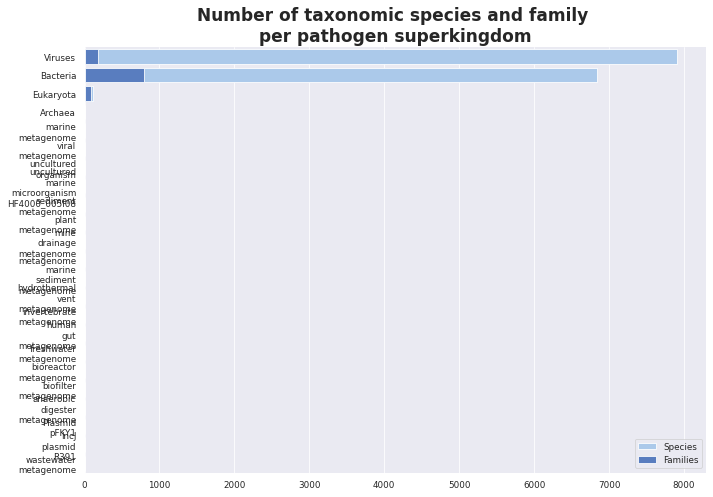

In [52]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

sns.set_theme(context="paper", style="darkgrid")

sns.set_color_codes("pastel")
sns.barplot(x="Species name", y="Species superkingdom", data=overview.sort_values("Species name", ascending=False).reset_index(),
            label="Species", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Species family", y="Species superkingdom", data=overview.sort_values("Species name", ascending=False).reset_index(),
            label="Families", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)

ax.set(ylabel="", xlabel="")

ax.set_title("Number of taxonomic species and family \nper pathogen superkingdom", fontdict=title_params)

yticks = ax.get_yticks().tolist()
yticks[7] = "uncultured marine\nmicroorganism HF4000_005I08"
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels[7] = "uncultured marine\nmicroorganism HF4000_005I08"
# for label in labels:
#     label = label.replace(" ", "\n")

ax.set_yticklabels(ax.get_yticklabels()) ## mod
    
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig("Superkingdom_family_species_bar.png")

<a id="filter"></a>

In [53]:
# Filter to include only viruses
df = df[df['Species superkingdom'] == 'Viruses']

In [54]:
df.sample(5)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Taxonomic lineage (SPECIES),Species name,Species superkingdom,Species family
7597,1914209,,Escherichia phage RB14,Long tail fiber protein p37 (Receptor-recogniz...,Escherichia virus RB14,Escherichia virus RB14,Viruses,Myoviridae
715,31657,,Pestivirus sp.,Autoprotease p20 (EC 2.7.7.48) (EC 3.4.21.113)...,Pestivirus sp.,Pestivirus sp.,Viruses,Flaviviridae
14727,2845749,,Paenibacillus phage Wanderer; Paenibacillus ph...,Integrase; Portal protein,Paenibacillus phage LincolnB,Paenibacillus virus Wanderer,Viruses,Siphoviridae
406,10385,Bos taurus (Bovine) [TaxID: 9913]; Panthera le...,Bovine herpesvirus 4 (BoHV-4) (Movar virus),Envelope glycoprotein B (gB); Capsid vertex co...,Bovine herpesvirus 4 (BoHV-4) (Movar virus),Bovine gammaherpesvirus 4,Viruses,Herpesviridae
2464,330399,,Listeria phage A006,Integrase,Listeria phage A006,Listeria phage A006,Viruses,Siphoviridae


In [55]:
df.drop(['Taxonomic lineage (SPECIES)'], axis=1, inplace=True)

In [56]:
# Convert empty strings to nan for easy downstream processing
df['Virus hosts'] = np.where(df['Virus hosts']=='', np.nan, df['Virus hosts'])

In [57]:
df[df['Virus hosts'].isnull()].sample(3)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Species name,Species superkingdom,Species family
12494,2592221,NaN,Salmonella phage SW3,Tail protein; Portal protein,Salmonella phage SW3,Viruses,Myoviridae
8094,1965486,NaN,Staphylococcus phage IME1318_01,Integrase,Staphylococcus phage IME1318_01,Viruses,Siphoviridae
13057,2675248,NaN,Lactococcus phage CHPC148,Portal protein,Lactococcus phage CHPC148,Viruses,Siphoviridae


In [58]:
df.drop('Organism', axis=1, inplace=True) # Organism == Species name

## Updating host names from other host data in the dataset

Premise: Same virus has same host irrespective of whether the info has been reviewed or not

In [59]:
# List of viruses which do not have assigned hosts in the data
noHostViruses = (df[df['Virus hosts'].isnull()]['Species name']
                 .unique()
                 .tolist())

In [60]:
# Create independent dataframe of viruses with no assigned host and simltaneously identify the same viruses from the data 
# whcih already have assigned hosts and assign host names based on those. 
df_na_hosts = df[(~df['Virus hosts'].isnull()) & (df['Species name'].isin(noHostViruses))][['Species name', 'Virus hosts']]
df_na_hosts = df_na_hosts.groupby('Species name')['Virus hosts'].apply(list) # Reduces dimention
df_na_hosts = df_na_hosts.reset_index(name='Viral hosts nw')

In [61]:
# Previous operation reurns a list for multiple host
# Converts the lists into regular string entries separated by a ;
df_na_hosts['Viral hosts nw'] = (df_na_hosts['Viral hosts nw']
                                 .swifter.progress_bar(desc='Joining host names list', enable=True)
                                 .apply('; '.join))

In [62]:
# Updates the viruses hosts info in the main dataset
df_naa = (df[df['Virus hosts'].isnull()]
          .merge(df_na_hosts, on='Species name', how='left')
          .drop('Virus hosts', axis=1)
          .rename({'Viral hosts nw':'Virus hosts'}, axis=1))

In [63]:
# Creates independant dataset with viruses which have hosts
df_notna = df[~df['Virus hosts'].isnull()]

In [64]:
# merges the updated virus hosts dataset with the dataset with viruses which have hosts
df = df_naa.append(df_notna)

In [65]:
df.shape # Reduced dimention because of grouping, will later ungroup

(7903, 6)

In [66]:
df.sample(5)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
1717,1573458,Integrase,Pseudomonas phage PS-1,Viruses,Siphoviridae,NaN
297,205869,Integrase; Uncharacterized protein,Mycobacterium virus CJW1,Viruses,Siphoviridae,NaN
5635,2664402,Portal protein,Streptococcus phage phi-SsuNJ5_rum,Viruses,Siphoviridae,NaN
4742,2558248,Penton protein (CP-P) (Penton base protein) (P...,Adenoviridae sp.,Viruses,Adenoviridae,NaN
4790,2560322,Hemagglutinin-neuraminidase (EC 3.2.1.18),Avian orthoavulavirus 16,Viruses,Paramyxoviridae,NaN


In [67]:
print(df[df['Virus hosts'].isnull()].shape)
df[df['Virus hosts'].isnull()].sample(3)

(7299, 6)


,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
2681,1965369,Collar/head-to-tail joining protein,Marinomonas phage CPG1g,Viruses,Autographiviridae,NaN
1658,1540096,Tape measure protein (TMP),Citrobacter virus Stevie,Viruses,Drexlerviridae,NaN
472,329290,Capsid protein (Coat protein),Malvastrum leaf curl virus,Viruses,Geminiviridae,NaN


In [68]:
df['Virus hosts'] = np.where(df['Virus hosts'].isnull(), '', df['Virus hosts'])

In [69]:
df.sample(3)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
2701,1965491,Integrase; Portal protein,Staphylococcus phage IME1367_01,Viruses,Siphoviridae,
1653,1536592,Putative portal protein,Idiomarinaceae phage 1N2-2,Viruses,Siphoviridae,
6215,2733872,Portal protein (Head-to-tail connector); Inter...,Escherichia virus 64795ec1,Viruses,Autographiviridae,


In [70]:
df = mergeRows(df, 'Species taxonomic ID','Virus hosts') # mergeRows in zoonosis_helper_functions.py

In [71]:
df[(df['Species name'].str.contains('Influenza A virus')) & (df['Virus hosts'] != '')]

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family
157,11320,; Aves [TaxID: 8782]; Mustela lutreola (Europe...,Nucleoprotein; Nucleoprotein (Nucleocapsid pro...,Influenza A virus,Viruses,Orthomyxoviridae


In [72]:
df.sample(3)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family
1962,1406341,Thermus thermophilus [TaxID: 274],Integrase,Thermus phage G20c,Viruses,Siphoviridae
99,10830,; Datura stramonium (Jimsonweed) (Common thorn...,Capsid protein (Coat protein) (CP); Capsid pro...,Tobacco yellow dwarf virus,Viruses,Geminiviridae
3303,1980476,,Envelope polyprotein (M polyprotein),Laguna Negra orthohantavirus,Viruses,Hantaviridae


In [73]:
# Separate dataset for easy tracking of updates
dfna = df[df['Virus hosts'] == '']
df = df[~(df['Virus hosts'] == '')]

In [74]:
dfna.shape

(7299, 6)

In [75]:
df.shape

(604, 6)

In [76]:
track_na_size = dict()
track_na_size.update({"Internal Update": dfna.shape[0]})
track_na_size

{'Internal Update': 7299}

In [77]:
track_df_size = dict()
track_df_size.update({"Internal Update": df.shape[0]})
track_df_size

{'Internal Update': 604}

## Updating host names from external sources

In [78]:
# Data from NCBI Virus
df2 = pd.read_csv('../data/sequences.csv')
df2.shape

(2599675, 3)

In [79]:
df2.sample(2)

,Species,Molecule_type,Host
1756470,Human immunodeficiency virus 1,ssRNA-RT,Homo sapiens
1422666,Influenza A virus,ssRNA(-),Homo sapiens


In [80]:
df2.drop_duplicates(inplace=True)
df2.shape

(10956, 3)

In [81]:
# Get taxonomic IDs from species names
df2['Species ID'], df2['Host ID'] = df2['Species'].progress_apply(getIDfromName), df2['Host'].progress_apply(getIDfromName)

Getting Species name:   0%|          | 0/10956 [00:00<?, ?it/s]

'Bovine associated bovismacovirus 1'
'Human associated porprismacovirus 1'
'Torque teno seal virus 8'
'Bovine associated porprismacovirus 1'
'Sheep associated porprismacovirus 3'
'Sheep associated porprismacovirus 1'
'Sheep associated porprismacovirus 2'
'Bovine associated bovismacovirus 2'
'Bovine associated huchismacovirus 1'
'Bovine associated drosmacovirus 1'
'Bovine associated cosmacovirus 1'
'Bovine associated huchismacovirus 2'
'Torque teno seal virus 5'
'nan'
'nan'
'nan'
'nan'


Getting Species name:   0%|          | 0/10956 [00:00<?, ?it/s]

'Bolomys lasiurus'
'Bolomys lasiurus'
'Equus asinus x caballus'
'Pipistrellus sp. pipistrellus/pygmaeus AO-2021'
'Pipistrellus musciculus'
'Funisciurus bayonii'
'Rattus sp. r3 YH-2020'
'Rattus sp. r3 YH-2020'
'Soricidae sp. YH-2020'
'Rattus sp. r3 YH-2020'
'Rattus sp. r3 YH-2020'
'Acomys selousi'
'Rhinolophus smithersi'
'Alouatta sp.'
'Pipistrellys abramus'
'Sturnira angeli'
'Sturnira angeli'
'Hipposideros curtus'
'Pipistrellus inexspectatus'
'Dobsonia exoleta'
'Mops demonstrator'
'Pipistrellus musciculus'
'Mus sp. TG-2020'
'Murinae gen. sp. TG-2020'
'Vespadelus baverstocki'
'Ozimops sp. DP-2019'
'Scoterepens balstoni'
'Neoromicia capensis'
'Neoromicia capensis'
'Mus sp. CL-2019'
'Mus sp. CL-2019'
'Neoromicia capensis'
'Equus asinus x caballus'
'Equus caballus x asinus'
'Bolomys lasiurus'
'Bolomys lasiurus'
'Bolomys lasiurus'
'Neoromicia capensis'
'Neoromicia capensis'
'Neoromicia capensis'
'Neoromicia capensis'
'Bolomys lasiurus'
'Pipistrellus inexspectatus'
'Chiroptera sp.'
'Chaereph

In [82]:
df2.dropna(inplace=True)
df2['Species ID'], df2['Host ID'] = df2['Species ID'].astype(int), df2['Host ID'].astype(int)
df2.shape

(10866, 5)

In [83]:
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['Host'], x['Host ID']), axis=1)
# Remove Host and Host ID columns as they have been merged and are no longer needed
df2.drop(['Host', 'Host ID'], axis=1, inplace=True)

Getting Species name:   0%|          | 0/10866 [00:00<?, ?it/s]

In [84]:
df2['Species ID'] = df2['Species ID'].progress_apply(getRankID, rank='species')

Getting Species name:   0%|          | 0/10866 [00:00<?, ?it/s]

In [85]:
## Create a copy for later use
dfff = df2.copy()

In [86]:
# Add host names
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [87]:
dfna.shape

(6271, 6)

In [88]:
df.shape

(1632, 6)

In [89]:
track_na_size.update({"NCBI virus Update": dfna.shape[0]})

track_df_size.update({"NCBI virus Update": df.shape[0]})
track_df_size

{'Internal Update': 604, 'NCBI virus Update': 1632}

In [90]:
# Data from virus host database
df2 = pd.read_table('../data/virushostdb.tsv')
df2.head(3)

,virus tax id,virus name,virus lineage,refseq id,KEGG GENOME,KEGG DISEASE,DISEASE,host tax id,host name,host lineage,pmid,evidence,sample type,source organism
0,438782,Abaca bunchy top virus,Viruses; Monodnaviria; Shotokuvirae; Cressdnav...,"NC_010314, NC_010315, NC_010316, NC_010317, NC...",NaN,NaN,NaN,46838.0,Musa sp.,Eukaryota; Viridiplantae; Streptophyta; Strept...,17978886,"Literature, NCBI Virus, RefSeq",NaN,NaN
1,438782,Abaca bunchy top virus,Viruses; Monodnaviria; Shotokuvirae; Cressdnav...,"NC_010314, NC_010315, NC_010316, NC_010317, NC...",NaN,NaN,NaN,214697.0,Musa acuminata AAA Group,Eukaryota; Viridiplantae; Streptophyta; Strept...,17978886,Literature,NaN,NaN
2,1241371,Abalone herpesvirus Victoria/AUS/2009,Viruses; Duplodnaviria; Heunggongvirae; Peplov...,NC_018874,NaN,NaN,NaN,6451.0,Haliotidae,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,NaN,UniProt,NaN,NaN


In [91]:
df2 = df2[['virus tax id', 'virus name', 'host tax id', 'host name']].copy()
df2.drop_duplicates(inplace=True)
print(df2.shape)
df2.head()

(16612, 4)


,virus tax id,virus name,host tax id,host name
0,438782,Abaca bunchy top virus,46838.0,Musa sp.
1,438782,Abaca bunchy top virus,214697.0,Musa acuminata AAA Group
2,1241371,Abalone herpesvirus Victoria/AUS/2009,6451.0,Haliotidae
3,1241371,Abalone herpesvirus Victoria/AUS/2009,36100.0,Haliotis rubra
4,491893,Abalone shriveling syndrome-associated virus,37770.0,Haliotis diversicolor aquatilis


In [92]:
df2[df2['host tax id'].isnull()]

,virus tax id,virus name,host tax id,host name
1236,2662138,Bacteriophage Phobos,NaN,NaN
3750,1131416,Cucurbit mild mosaic virus,NaN,NaN
15925,1888308,Wabat virus,NaN,NaN


In [93]:
df2.dropna(inplace=True)

In [94]:
df2['host tax id'] = df2['host tax id'].astype(int)
df2.head()

,virus tax id,virus name,host tax id,host name
0,438782,Abaca bunchy top virus,46838,Musa sp.
1,438782,Abaca bunchy top virus,214697,Musa acuminata AAA Group
2,1241371,Abalone herpesvirus Victoria/AUS/2009,6451,Haliotidae
3,1241371,Abalone herpesvirus Victoria/AUS/2009,36100,Haliotis rubra
4,491893,Abalone shriveling syndrome-associated virus,37770,Haliotis diversicolor aquatilis


In [95]:
df2['Species ID'] = df2['virus tax id'].progress_apply(getRankID, rank='species')

Getting Species name:   0%|          | 0/16609 [00:00<?, ?it/s]

In [96]:
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['host name'], x['host tax id']), axis=1)
# Remove Host and Host ID columns as they have been merged and are no longer needed
df2.drop(['host name', 'host tax id'], axis=1, inplace=True)
df2.head()

Getting Species name:   0%|          | 0/16609 [00:00<?, ?it/s]

,virus tax id,virus name,Species ID,Host name
0,438782,Abaca bunchy top virus,438782,Musa sp. [TaxID: 46838]
1,438782,Abaca bunchy top virus,438782,Musa acuminata AAA Group [TaxID: 214697]
2,1241371,Abalone herpesvirus Victoria/AUS/2009,1513231,Haliotidae [TaxID: 6451]
3,1241371,Abalone herpesvirus Victoria/AUS/2009,1513231,Haliotis rubra [TaxID: 36100]
4,491893,Abalone shriveling syndrome-associated virus,491893,Haliotis diversicolor aquatilis [TaxID: 37770]


In [97]:
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [98]:
df.shape

(4731, 6)

In [99]:
dfna.shape

(3172, 6)

In [100]:
track_na_size.update({"Virus-Host DB Update": dfna.shape[0]})

track_df_size.update({"Virus-Host DB Update": df.shape[0]})
track_df_size

{'Internal Update': 604,
 'NCBI virus Update': 1632,
 'Virus-Host DB Update': 4731}

In [101]:
# Data from EID2 (Liverpool University)
df2 = pd.read_csv('../data/virus_host_4rm_untitled.csv')
df2.sample(2)

,Host_name,Host_TaxId,Host Group,Virus_name,Virus_TaxId,Micobe_group,Host_common_name,Host_common_name_rev
34014,homo sapiens,9606,primates,influenza a virus (a/texas/af1625/2008(h3n2)),530463,viruses,Human,Human
34265,homo sapiens,9606,primates,influenza a virus (a/arkansas/af1373/2008(h3n2)),530210,viruses,Human,Human


In [102]:
df2 = df2[['Host_name', 'Host_TaxId', 'Virus_name', 'Virus_TaxId']].copy()
df2['Species ID'] = df2['Virus_TaxId'].progress_apply(getRankID, rank='species')
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['Host_name'], x['Host_TaxId']), axis=1)
df2.drop(['Host_name', 'Host_TaxId'], axis=1, inplace=True)
df2.dropna(inplace=True)
df2.sample(2)

Getting Species name:   0%|          | 0/59859 [00:00<?, ?it/s]

878474 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found


Getting Species name:   0%|          | 0/59859 [00:00<?, ?it/s]

,Virus_name,Virus_TaxId,Species ID,Host name
20912,influenza a virus (a/argentina/hnrg1184/2009(h...,754713,11320.0,homo sapiens [TaxID: 9606]
20023,influenza a virus (a/california/vrdl137/2009(h...,765446,11320.0,homo sapiens [TaxID: 9606]


In [103]:
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [104]:
df.shape

(4737, 6)

In [105]:
dfna.shape

(3166, 6)

In [106]:
dfna.sample(2)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
742,1972433,Portal protein,Corynebacterium phage LGCM-V2,Viruses,Siphoviridae,NaN
2002,2560581,Envelope glycoprotein B (gB); Capsid vertex co...,Mandrilline betaherpesvirus 1,Viruses,Herpesviridae,NaN


In [107]:
track_na_size.update({"EID2 Update": dfna.shape[0]})

track_df_size.update({"EID2 Update": df.shape[0]})
track_df_size

{'Internal Update': 604,
 'NCBI virus Update': 1632,
 'Virus-Host DB Update': 4731,
 'EID2 Update': 4737}

In [108]:
track_na_size

{'Internal Update': 7299,
 'NCBI virus Update': 6271,
 'Virus-Host DB Update': 3172,
 'EID2 Update': 3166}

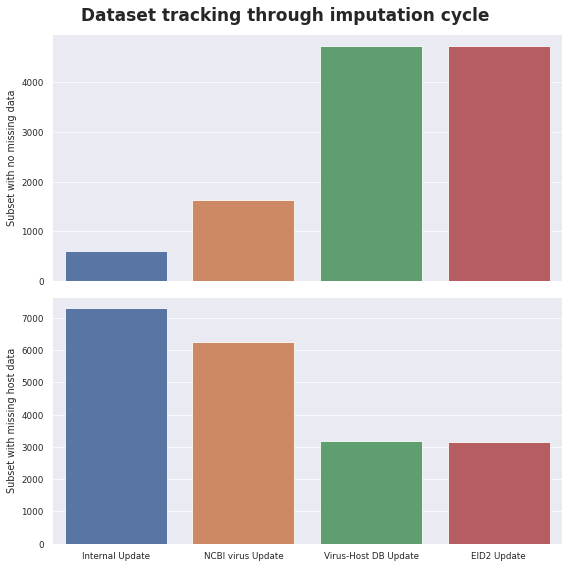

In [109]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

fig.suptitle('Dataset tracking through imputation cycle', fontsize=17, fontweight="bold")

sns.set_theme(context="paper", style="darkgrid")

sns.barplot(data=pd.DataFrame().from_records([track_df_size]), ax=ax[0])

sns.barplot(data=pd.DataFrame().from_records([track_na_size]), ax=ax[1])

ax[0].set_ylabel("Subset with no missing data")
ax[1].set_ylabel("Subset with missing host data")

plt.tight_layout()
plt.savefig("Tracking.png")

## Further Processing

In [110]:
# Add column to discriminate viruses which contain human hosts from those which do not
df['Infects human'] = np.where(df['Virus hosts'].str.contains(r'960[56]'), 'human-true','human-false')

In [111]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
1771,1431748,Mus musculus [TaxID: 10090]; Myodes glareolus ...,Envelope glycoprotein B (gB); Capsid vertex co...,Murine herpesvirus,Viruses,Herpesviridae,human-false
45,10537,; Canis lupus familiaris (Dog) (Canis familiar...,Pre-histone-like nucleoprotein (Pre-core prote...,Canine mastadenovirus A,Viruses,Adenoviridae,human-false


In [112]:
df['Virus hosts'] = df['Virus hosts'].str.split('; ')
df['Virus hosts'] = df.progress_apply(lambda x: list(filter(None, x['Virus hosts'])), axis=1) # remove empty items
df['Virus hosts'] = df['Virus hosts'].progress_apply('; '.join)

Getting Species name:   0%|          | 0/4737 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/4737 [00:00<?, ?it/s]

In [113]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
4446,2844803,Homo sapiens [TaxID: 9606],CA1 (Capsid protein) (Coat protein),Gyrovirus homsa2,Viruses,Anelloviridae,human-true
2636,1982558,Gordonia terrae [TaxID: 2055],Integrase,Gordonia virus Bachita,Viruses,Siphoviridae,human-false
814,337048,Homo sapiens (Human) [TaxID: 9606],Major capsid protein L1; Minor capsid protein L2,Alphapapillomavirus 1,Viruses,Papillomaviridae,human-true
2720,1985740,Pseudomonas putida [TaxID: 303],Portal protein (Head-to-tail connector),Pseudomonas virus gh1,Viruses,Autographiviridae,human-false


In [114]:
df[df['Infects human'] == 'human-true'].sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
31,10376,Homo sapiens (Human) [TaxID: 9606],Envelope glycoprotein H (gH); Envelope glycopr...,Human gammaherpesvirus 4,Viruses,Herpesviridae,human-true
2533,1972577,Bos taurus (Bovine) [TaxID: 9913]; Homo sapien...,G protein; Glycoprotein; Uncharacterized protein,Indiana vesiculovirus,Viruses,Rhabdoviridae,human-true
591,194440,Homo sapiens (Human) [TaxID: 9606],Gag-Pro-Pol polyprotein (Integrase) (Matrix pr...,Primate T-lymphotropic virus 1,Viruses,Retroviridae,human-true
727,277944,Homo sapiens (Human) [TaxID: 9606],Spike glycoprotein (S glycoprotein) (E2) (Pepl...,Human coronavirus NL63,Viruses,Coronaviridae,human-true


<a id="host-name-consistency"></a>

In [115]:
# Ungrouping operation based on host
# 1. Splits Virus host using based on ; separator
# 2. Horizontally stack the data based on virus hosts
df = (df.set_index(df.columns.drop('Virus hosts', 1).tolist())['Virus hosts'].str.split(';', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Virus hosts'})
          .loc[:, df.columns]
         ).copy()

In [116]:
df.shape

(7247, 7)

In [117]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
6820,2843991,Clostridium perfringens [TaxID: 1502],Pre-neck appendage protein,Clostridium virus phiCPV4,Viruses,Guelinviridae,human-false
4674,1983447,Mycolicibacterium smegmatis MC2 155 [TaxID: 24...,Integrase,Mycobacterium phage Shandong1,Viruses,Siphoviridae,human-false
6300,2733645,Escherichia coli [TaxID: 562],Portal protein (Head-to-tail connector); Inter...,Escherichia virus YZ1,Viruses,Autographiviridae,human-false
55,10326,Equus caballus (Horse) [TaxID: 9796],Membrane glycoprotein C; Envelope glycoprotein...,Equid alphaherpesvirus 1,Viruses,Herpesviridae,human-false


In [118]:
df['Virus hosts ID'] = None
idx_organism = df.columns.get_loc('Virus hosts')
idx_host_id = df.columns.get_loc('Virus hosts ID')

pattern = r'(\d+)\]' # The last digit on some IDs was not captured so include the ] to capture & later remove
for row in range(len(df)):
    host_id = re.search(pattern, df.iat[row, idx_organism]).group()
    df.iat[row, idx_host_id] = host_id
df.head()

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID
0,10243,Homo sapiens (Human) [TaxID: 9606],Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,9606]
1,10243,Bos taurus (Bovine) [TaxID: 9913],Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,9913]
2,10243,Myodes glareolus (Bank vole) (Clethrionomys g...,Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,447135]
3,10243,Felis catus (Cat) (Felis silvestris catus) [T...,Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,9685]
4,10243,Microtus agrestis (Short-tailed field vole) [...,Envelope protein A28 homolog (Protein CPXV163)...,Cowpox virus,Viruses,Poxviridae,human-true,29092]


In [119]:
df['Virus hosts ID'] = df['Virus hosts ID'].str.strip('\]')

In [120]:
df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(int)

df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(getRankID, rank='species')
df['Virus host name'] = df['Virus hosts ID'].progress_apply(getRankName, rank='species')
df['Host superkingdom'] = df['Virus hosts ID'].progress_apply(getRankName, rank='superkingdom')
df['Host kingdom'] = df['Virus hosts ID'].progress_apply(getRankName, rank='kingdom')

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

In [121]:
df[df['Virus hosts ID'].isna()]

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom


In [122]:
df['Virus hosts ID'][1866]

229543

In [123]:
df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(int)

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

In [124]:
df['Virus hosts'] = (df.drop('Virus hosts', axis=1)
                     .apply(lambda x: nameMerger(x['Virus host name'], x['Virus hosts ID']), axis=1))

In [125]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
4499,1980465,Oligoryzomys fulvescens [TaxID: 218825],Envelope polyprotein (M polyprotein),Choclo orthohantavirus,Viruses,Hantaviridae,human-true,218825,Oligoryzomys fulvescens,Eukaryota,Metazoa
548,11970,Lagothrix [TaxID: 9518],Capsid protein p30 (CA); Nucleocapsid protein ...,Woolly monkey sarcoma virus,Viruses,Retroviridae,human-false,9518,Lagothrix,Eukaryota,Metazoa
2157,740971,Rousettus leschenaultii [TaxID: 9408],Pre-histone-like nucleoprotein (Pre-core prote...,Bat mastadenovirus,Viruses,Adenoviridae,human-false,9408,Rousettus leschenaultii,Eukaryota,Metazoa
1315,185782,Notemigonus crysoleucas [TaxID: 28800],VP4 protein; Outer capsid protein VP5; Outer c...,Aquareovirus C,Viruses,Reoviridae,human-false,28800,Notemigonus crysoleucas,Eukaryota,Metazoa


In [126]:
df.shape

(7247, 11)

In [127]:
# Ungroup based on protein names
df = (df.set_index(df.columns.drop('Protein names',1).tolist())['Protein names']
          .str.split(';', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Protein names'})
          .loc[:, df.columns]
         ).copy()

In [128]:
df.shape

(22528, 11)

In [129]:
df[df["Species name"] == "Vaccinia virus"]["Virus hosts"].unique()

array(['Homo sapiens [TaxID: 9606]', 'Bos taurus [TaxID: 9913]',
       'Equus caballus [TaxID: 9796]',
       'Oryctolagus cuniculus [TaxID: 9986]'], dtype=object)

In [130]:
df[df['Host superkingdom'].isnull()].shape

(0, 11)

In [131]:
df['Host superkingdom'].unique()

array(['Eukaryota', 'Bacteria', 'Viruses', 'root', 'Archaea'],
      dtype=object)

In [132]:
df[df['Host superkingdom'] == 'Eukaryota'].shape

(18356, 11)

In [133]:
df[df['Host superkingdom'] == 'Viruses'].shape

(4, 11)

In [134]:
df[df['Host superkingdom'] == 'Bacteria'].shape

(4116, 11)

In [135]:
df[df['Host superkingdom'] == 'root'].shape

(38, 11)

In [136]:
df[df['Host superkingdom'] == 'Archaea'].shape

(14, 11)

In [137]:
print(df[df['Host kingdom'] == 'Metazoa'].shape)
df[df['Host kingdom'] == 'Metazoa'].sample(3)

(17292, 11)


,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
5457,12542,Homo sapiens [TaxID: 9606],Non-structural protein 1 (NS1),Omsk hemorrhagic fever virus,Viruses,Flaviviridae,human-true,9606,Homo sapiens,Eukaryota,Metazoa
3287,11089,Simiiformes [TaxID: 314293],Non-structural protein 2A (NS2A),Yellow fever virus,Viruses,Flaviviridae,human-true,314293,Simiiformes,Eukaryota,Metazoa
16195,1891759,Dobsonia moluccensis [TaxID: 42147],Minor capsid protein,Dobsonia moluccensis polyomavirus 2,Viruses,Polyomaviridae,human-false,42147,Dobsonia moluccensis,Eukaryota,Metazoa


In [138]:
df[df['Infects human'] == 'human-true'].shape

(8442, 11)

In [139]:
df[df['Infects human'] == 'human-false'].shape

(14086, 11)

In [140]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
929,10245,Homo sapiens [TaxID: 9606],Entry-fusion complex protein (IMV protein) (M...,Vaccinia virus,Viruses,Poxviridae,human-true,9606,Homo sapiens,Eukaryota,Metazoa
3185,11086,Ovis aries [TaxID: 9940],Non-structural protein 4B (NS4B),Louping ill virus,Viruses,Flaviviridae,human-true,9940,Ovis aries,Eukaryota,Metazoa


In [141]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
22009,2844298,Flavobacterium sp. LMO6 [TaxID: 2654243],Portal protein,Flavobacterium virus Snusmum,Viruses,Siphoviridae,human-false,2654243,Flavobacterium sp. LMO6,Bacteria,Flavobacterium sp. LMO6
9975,232237,Xanthomonas oryzae [TaxID: 347],7R,Xanthomonas virus Xp10,Viruses,Siphoviridae,human-false,347,Xanthomonas oryzae,Bacteria,Xanthomonas oryzae


<a id="issue"></a>

In [142]:
## Virus host name != Virus hosts ### Shared names but not ID eg. Influenza A strain 4 & Influenza A strain 4 == same ID but diff name
for column in df.columns:
    print(column, df[column].nunique())
print('\nDataframe total',len(df))

Species taxonomic ID 4737
Virus hosts 1765
Protein names 2083
Species name 4737
Species superkingdom 1
Species family 85
Infects human 2
Virus hosts ID 1765
Virus host name 1756
Host superkingdom 5
Host kingdom 345

Dataframe total 22528


In [143]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
18419,2017720,Sus scrofa [TaxID: 9823],Viral protein genome-linked (VPg) (Protein 3B...,Porcine enterovirus b/BEL/15V010,Viruses,Picornaviridae,human-false,9823,Sus scrofa,Eukaryota,Metazoa
11560,740971,Hipposideros armiger [TaxID: 186990],Pre-histone-like nucleoprotein (Pre-core prote...,Bat mastadenovirus,Viruses,Adenoviridae,human-false,186990,Hipposideros armiger,Eukaryota,Metazoa


## Restructuring the data

In [144]:
# Earlier saved data
dff.sample(2)

,Entry,Species taxonomic ID,Length
195851,A9X004,11320.0,566
87354,I6QRN1,11320.0,566


In [145]:
dff.shape

(358333, 3)

In [146]:
## Load sequences
# Using custom IO instead of Bio.SeqIO because it was much easier to customise
# Not as efficient but still light on resources

<a id='fasta'></a>

In [147]:
%%time

fastaFileName = '../data/uniprot-keyword Virus+entry+into+host+cell+[KW-1160] +fragment no.fasta'

entry_seq = read_fasta(fastaFileName) # read_fasta in zoonosis_helper_functions.py

CPU times: user 3.26 s, sys: 645 ms, total: 3.91 s
Wall time: 3.9 s


In [148]:
dff.sort_values(by='Entry', inplace=True)

seq_object_list = [seq_obj for entry, seq_obj in entry_seq]

dff['Sequence'] = seq_object_list

In [149]:
dff.head()

,Entry,Species taxonomic ID,Length,Sequence
50368,A0A009FEK4,470.0,392,<zoonosis_helper_functions.FASTASeq object at ...
156673,A0A009G3H3,1310609.0,385,<zoonosis_helper_functions.FASTASeq object at ...
146717,A0A009GC36,470.0,400,<zoonosis_helper_functions.FASTASeq object at ...
146730,A0A009GCG0,470.0,410,<zoonosis_helper_functions.FASTASeq object at ...
144753,A0A009GXT7,1310609.0,399,<zoonosis_helper_functions.FASTASeq object at ...


In [150]:
df.drop(['Virus host name', 'Protein names', 'Species superkingdom'], axis=1, inplace=True)

In [151]:
%%time

df = df.merge(dff, on='Species taxonomic ID', how='left')

df.shape

CPU times: user 15.8 s, sys: 6.57 s, total: 22.3 s
Wall time: 22.3 s


(48729124, 11)

In [152]:
del dff, df2

In [153]:
%%time

df.drop_duplicates(inplace=True)
df.shape

CPU times: user 48 s, sys: 14.9 s, total: 1min 2s
Wall time: 1min 2s


(2277906, 11)

In [154]:
df['Virus hosts ID'] = df['Virus hosts ID'].apply(str)

In [155]:
df.head()

,Species taxonomic ID,Virus hosts,Species name,Species family,Infects human,Virus hosts ID,Host superkingdom,Host kingdom,Entry,Length,Sequence
0,10243,Homo sapiens [TaxID: 9606],Cowpox virus,Poxviridae,human-true,9606,Eukaryota,Metazoa,A0A0K2YUN2,340.0,<zoonosis_helper_functions.FASTASeq object at ...
1,10243,Homo sapiens [TaxID: 9606],Cowpox virus,Poxviridae,human-true,9606,Eukaryota,Metazoa,A0A1B5FLS7,377.0,<zoonosis_helper_functions.FASTASeq object at ...
2,10243,Homo sapiens [TaxID: 9606],Cowpox virus,Poxviridae,human-true,9606,Eukaryota,Metazoa,A0A1S5WL42,304.0,<zoonosis_helper_functions.FASTASeq object at ...
3,10243,Homo sapiens [TaxID: 9606],Cowpox virus,Poxviridae,human-true,9606,Eukaryota,Metazoa,A0A1V0FXA9,304.0,<zoonosis_helper_functions.FASTASeq object at ...
4,10243,Homo sapiens [TaxID: 9606],Cowpox virus,Poxviridae,human-true,9606,Eukaryota,Metazoa,A0A1V0FXG9,377.0,<zoonosis_helper_functions.FASTASeq object at ...


In [156]:
%%time

# Group by Entry and aggregate using set function to avoid duplication
df = (df.groupby('Entry', as_index=False)
       .agg({'Virus hosts':set, #'Protein':set, 
             'Infects human':set, 'Species name':set,
             'Host superkingdom':set,
             'Host kingdom':set,
             'Virus hosts ID':set,
             'Species family':set,
             'Species taxonomic ID':'first',
             'Sequence': 'first', 'Length': 'first',})) 

# joint the set columns into a string separated by a ;
# First column is 'Entry' so skip index 0, last 3 columns need not be joined
df.iloc[:, 1:-3] = df.iloc[:, 1:-3].swifter.applymap('; '.join)

Pandas Apply:   0%|          | 0/2222927 [00:00<?, ?it/s]

CPU times: user 26.6 s, sys: 642 ms, total: 27.3 s
Wall time: 27.2 s


In [157]:
df.shape

(317561, 11)

In [158]:
%%time

# Get additional sequence info from the dataset
df['Sequence'] = df.progress_apply(lambda x: getSequenceFeatures(
    seqObj=x['Sequence'], entry=x['Entry'],
    organism=x['Species name'], status=x['Infects human']), axis=1)

Pandas Apply:   0%|          | 0/317561 [00:00<?, ?it/s]

CPU times: user 9.32 s, sys: 131 ms, total: 9.45 s
Wall time: 9.4 s


<a id="protein-names-from-sequence"></a>

In [159]:
df['Protein'] = df['Sequence'].apply(lambda sequence: sequence.protein_name)

In [160]:
df.sample(3)

,Entry,Virus hosts,Infects human,Species name,Host superkingdom,Host kingdom,Virus hosts ID,Species family,Species taxonomic ID,Sequence,Length,Protein
84870,A0A1S6QU39,Homo sapiens [TaxID: 9606],human-true,Influenza B virus,Eukaryota,Metazoa,9606,Orthomyxoviridae,11520,<zoonosis_helper_functions.FASTASeq object at ...,560.0,Nucleoprotein
11126,A0A089G5M6,Homo sapiens [TaxID: 9606]; Mustela lutreola [...,human-true,Influenza A virus,Eukaryota,Metazoa,8830; 9031; 9709; 9796; 9761; 9694; 9666; 9685...,Orthomyxoviridae,11320,<zoonosis_helper_functions.FASTASeq object at ...,566.0,Hemagglutinin
36927,A0A0N9RGS1,Homo sapiens [TaxID: 9606],human-true,Influenza B virus,Eukaryota,Metazoa,9606,Orthomyxoviridae,11520,<zoonosis_helper_functions.FASTASeq object at ...,560.0,Nucleoprotein


In [161]:
df[df['Infects human'] == 'human-true'].shape

(278791, 12)

In [162]:
df[df['Infects human'] == 'human-false'].shape

(38770, 12)

In [163]:
# Sequences loaded earlier from NCBI Virus ###Add Molecule type
dfff.rename({'Species ID': 'Species taxonomic ID', 'Molecule_type': 'Molecule type'}, axis=1, inplace=True)
dfff.head()

,Species,Molecule type,Species taxonomic ID,Host name
0,Epsilonarterivirus zamalb,ssRNA(+),2501966,Chlorocebus [TaxID: 392815]
1,Rodent arterivirus,ssRNA(+),1806636,Eothenomys inez [TaxID: 870526]
2,Wencheng Sm shrew coronavirus,ssRNA(+),1508228,Suncus murinus [TaxID: 9378]
3,Bat coronavirus,ssRNA(+),1508220,Eidolon helvum [TaxID: 77214]
4,NL63-related bat coronavirus strain BtKYNL63-9b,ssRNA(+),2501929,Triaenops afer [TaxID: 549403]


In [164]:
df['Species taxonomic ID'] = df['Species taxonomic ID'].apply(int)

In [165]:
%%time

df = df.merge(dfff[['Species taxonomic ID', 'Molecule type']], how='left', on='Species taxonomic ID')

CPU times: user 3.89 s, sys: 1.59 s, total: 5.48 s
Wall time: 5.48 s


In [166]:
df.shape

(8419758, 13)

In [167]:
%%time

df.drop_duplicates(inplace=True)

CPU times: user 12.5 s, sys: 2.68 s, total: 15.2 s
Wall time: 15.2 s


In [168]:
df.shape

(317561, 13)

In [169]:
del dfff

## Reorganise dataframe

In [170]:
df = df[['Entry', 'Protein', 'Length', 'Species name', 
         'Species taxonomic ID', 'Species family', 'Virus hosts',
         'Virus hosts ID', 'Host kingdom', 
         'Host superkingdom', 'Molecule type', 'Infects human', 'Sequence']]

In [171]:
df.sample(2)

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence
8321454,X2E3H0,Nucleoprotein,560.0,Influenza B virus,11520,Orthomyxoviridae,Homo sapiens [TaxID: 9606],9606,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...
7209076,M9QME9,Hemagglutinin,566.0,Influenza A virus,11320,Orthomyxoviridae,Homo sapiens [TaxID: 9606]; Mustela lutreola [...,8830; 9031; 9709; 9796; 9761; 9694; 9666; 9685...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...


## Split Dataframe to multiple datasets

In [172]:
df['Host superkingdom'].unique()

array(['Eukaryota', 'Bacteria', 'root', 'Archaea', 'Viruses',
       'Eukaryota; root'], dtype=object)

In [173]:
df['Host kingdom'].unique()

array(['Metazoa', 'Viridiplantae', 'Lactococcus lactis',
       'Escherichia coli', 'Serratia marcescens',
       'Mycolicibacterium smegmatis', 'Bacillus thuringiensis',
       'Trichormus variabilis', 'Listeria monocytogenes',
       'Pseudomonas syringae', 'Viridiplantae; Metazoa',
       'Cronobacter sakazakii', 'Staphylococcus epidermidis',
       'Enterococcus faecium', 'root', 'Caulobacter vibrioides',
       'Vibrio alginolyticus', 'Staphylococcus aureus', 'Bacillus cereus',
       'Ralstonia solanacearum', 'Klebsiella pneumoniae',
       'Staphylococcus xylosus; Staphylococcus aureus',
       'Acinetobacter baumannii', 'Dickeya sp.',
       'Lactobacillus delbrueckii', 'Salmonella', 'Bacillus pumilus',
       'Citrobacter; Citrobacter freundii', 'Mycobacterium',
       'Rhizobium leguminosarum', 'Mesorhizobium loti',
       'Shigella flexneri', 'Yersinia enterocolitica',
       'Idiomarinaceae bacterium N2-2', 'Sulfitobacter sp. CB2047',
       'Lelliottia sp. GL2', 'Clostridi

In [174]:
df[(df['Host kingdom'].str.contains('Viridiplantae')) | df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens')].shape

(284539, 13)

In [175]:
title_params

{'fontsize': 17, 'fontweight': 'bold'}

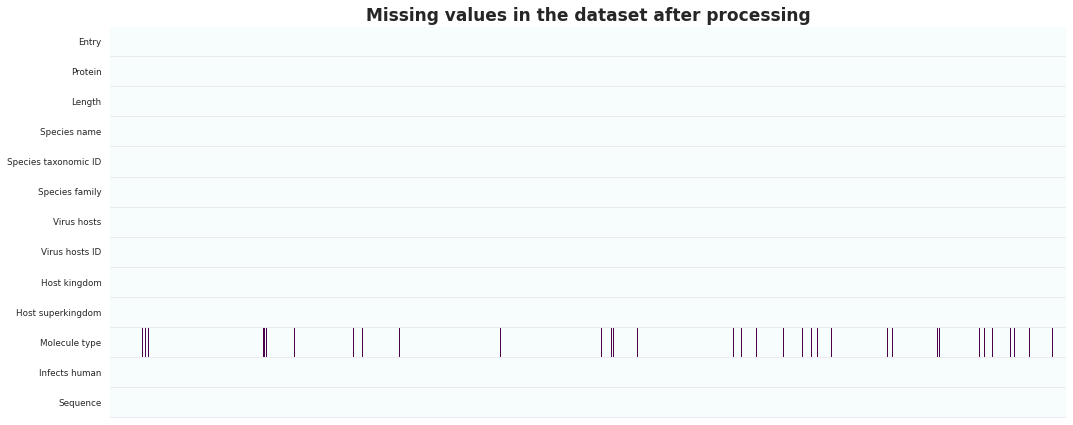

In [176]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df.copy().T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

ax.set_title("Missing values in the dataset after processing", fontdict=title_params)

plt.tight_layout()
plt.savefig("Processed_heatmap.png")

In [177]:
df['Molecule type'] = np.where(df['Molecule type'].isna(), '', df['Molecule type'])

In [178]:
df[df['Molecule type'].isna()]

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence


In [179]:
df[df['Host kingdom'].str.contains('Metazoa')][df[df['Host kingdom'].str.contains('Metazoa')]['Molecule type']
                                               .str.contains('DNA')].shape

(31523, 13)

In [180]:
df[df['Host kingdom'].str.contains('Metazoa')][df[df['Host kingdom'].str.contains('Metazoa')]['Molecule type']
                                               .str.contains('RNA')].shape

(273090, 13)

In [181]:
df.shape

(317561, 13)

In [182]:
df[~df['Host kingdom'].str.contains('Metazoa')].shape

(10233, 13)

In [183]:
df[(df['Host superkingdom'].isin(['Bacteria', 'Viruses', 'Archaea'])) |
   (df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens'))].shape

(283447, 13)

In [184]:
unfiltered = df.copy()

metazoa = df[df['Host kingdom'].str.contains('Metazoa')].copy()

plant_human = df[(df['Host kingdom'].str.contains('Viridiplantae')) |
                 df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens')].copy()

NonEukaryote_Human = df[(df['Host superkingdom'].isin(['Bacteria', 'Viruses', 'Archaea'])) |
                        (df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens'))].copy()

DNA_MetazoaZoonosis = metazoa[metazoa['Molecule type'].str.contains('DNA')].copy()

RNA_MetazoaZoonosis = metazoa[metazoa['Molecule type'].str.contains('RNA')].copy()

In [185]:
df.groupby("Infects human").agg(lambda x: len(set(x)))

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Sequence
Infects human,,,,,,,,,,,,
human-false,38770,871,1650.0,4390,4390,77,1407,1405,375,6,12,38770
human-true,278791,319,1278.0,346,346,33,143,143,2,1,12,278791


In [186]:
def check_dist(df):
    true_count = df[df['Infects human'].str.contains('true')].shape[0]
    false_count = df[df['Infects human'].str.contains('false')].shape[0]
    imb = (false_count/true_count)
    print('The minoity class is %.2f of the majority\nhuman-true == %d and human false == %d\n' % (imb, true_count, false_count))

In [187]:
dataframes = [metazoa, unfiltered, plant_human, NonEukaryote_Human, DNA_MetazoaZoonosis, RNA_MetazoaZoonosis]
for dt in dataframes:
    check_dist(dt)

The minoity class is 0.10 of the majority
human-true == 278757 and human false == 28571

The minoity class is 0.14 of the majority
human-true == 278791 and human false == 38770

The minoity class is 0.02 of the majority
human-true == 278791 and human false == 5748

The minoity class is 0.02 of the majority
human-true == 278757 and human false == 4690

The minoity class is 0.29 of the majority
human-true == 24518 and human false == 7005

The minoity class is 0.07 of the majority
human-true == 254070 and human false == 19020



In [188]:
# df.head()

In [189]:
# pd.melt(df.sample(100), value_vars="Infects human")

In [190]:
df["Molecule type"].unique()

array(['ssRNA(+)', 'ssRNA(-)', 'dsDNA', 'ssRNA-RT', '', 'ssRNA(+/-)',
       'ssDNA(+/-)', 'dsRNA', 'dsDNA-RT', 'ssDNA(-)', 'unknown', 'ssDNA',
       'RNA'], dtype=object)

## Random Undersampling of datasets

In [192]:
seed = 960505

In [193]:
# Undersample majority class such that minority class (human-false) is 60% of the majority class (human-true317316)
rus = RandomUnderSampler(sampling_strategy=0.6, random_state=seed)
sampled_dataframes = []
for dt in dataframes:
    clas = dt['Infects human']
#     print('Dataframe before sampling: ', dt.shape[0])
    dt, _ = rus.fit_resample(dt, clas)
    sampled_dataframes.append(dt)
    check_dist(dt)
#     print('Dataframe after sampling: ', dt.shape[0])

The minoity class is 0.60 of the majority
human-true == 47618 and human false == 28571

The minoity class is 0.60 of the majority
human-true == 64616 and human false == 38770

The minoity class is 0.60 of the majority
human-true == 9580 and human false == 5748

The minoity class is 0.60 of the majority
human-true == 7816 and human false == 4690

The minoity class is 0.60 of the majority
human-true == 11675 and human false == 7005

The minoity class is 0.60 of the majority
human-true == 31700 and human false == 19020



In [194]:
metazoaFile = 'MetazoaZoonosis'
plant_humanFile = 'Plant-HumanZoonosis'
unfilteredFile = 'Zoonosis'
NonEukaryote_HumanFile = 'NonEukaryote-Human'
DNA_metazoaFile = 'DNA-MetazoaZoonosis'
RNA_metazoaFile = 'RNA-MetazoaZoonosis'

In [195]:
def plot_strips(df, title, save):
    proteins = "Protein"
    hosts = "Virus hosts"
    status = "Infects human"
    vals = [proteins, hosts, status]
    df = df.copy()
    
    df = (df.set_index(df.columns.drop('Virus hosts', 1).tolist())['Virus hosts'].str.split('; ', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Virus hosts'})
          .loc[:, df.columns]
         ).copy()
    
    
    true_overview = pd.pivot_table(df[df["Infects human"] == "human-true"], values=vals,
                                   index="Species name",
                                   aggfunc={
                                       proteins: lambda x: len(set(x)),
                                       hosts: lambda x: len(set(x))
                                   }
                                  )

    false_overview = pd.pivot_table(df[df["Infects human"] == "human-false"], values=vals,
                                    index="Species name",
                                    aggfunc={
                                        proteins: lambda x: len(set(x)),
                                        hosts: lambda x: len(set(x))
                                    }
                                   )
    
    # return true_overview.sample(5)
    fig, ax = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='col', figsize=(8,8))
    sns.set_theme(context="paper", style="darkgrid")

    fig.suptitle(title, fontsize=17, fontweight="bold")
    
    sns.set_palette("Dark2")
    sns.stripplot(y=true_overview[proteins], ax=ax[0, 0])
    sns.stripplot(y=false_overview[proteins], ax=ax[1, 0])
    
    sns.set_palette("tab20b")
    sns.stripplot(y=true_overview[hosts], ax=ax[0, 1])
    sns.stripplot(y=false_overview[hosts], ax=ax[1, 1])

    ax[1, 0].set_xlabel('Virus proteins',)
    ax[1, 1].set_xlabel('Virus hosts')

    ax[0, 1].set_ylabel('')
    ax[1, 1].set_ylabel('')
    
    ax[0, 0].set_ylabel('Human True')
    ax[1, 0].set_ylabel('Human False')

    fig.tight_layout()
    plt.savefig(save)

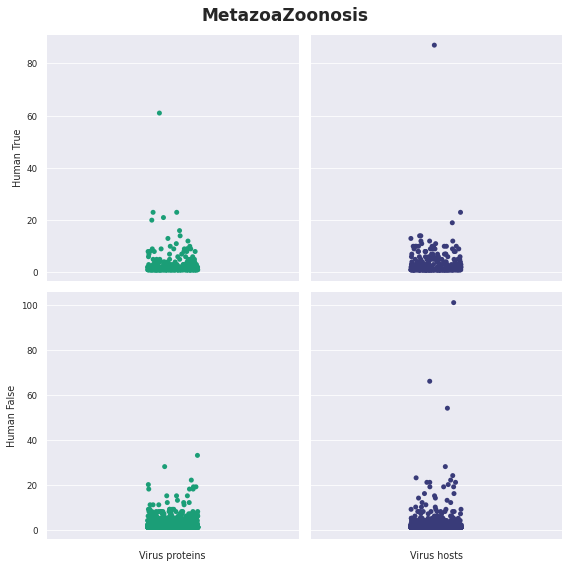

In [196]:
plot_strips(df=metazoa, title='MetazoaZoonosis', save="MetazoaZoonosis_Protein_host_stripplot.png")

CPU times: user 1min 5s, sys: 11.5 s, total: 1min 17s
Wall time: 1min 15s


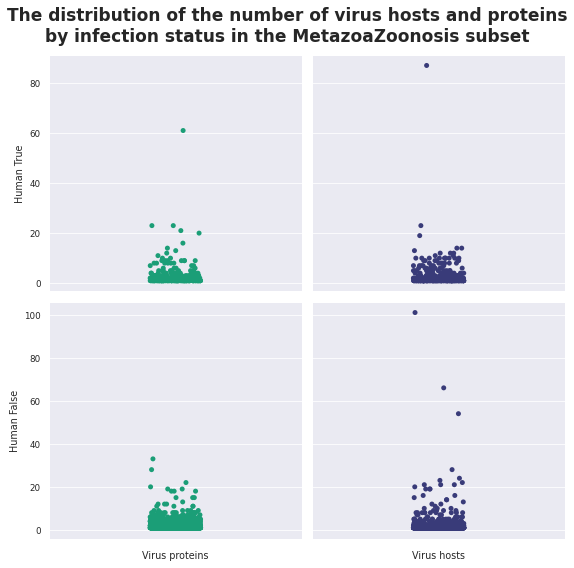

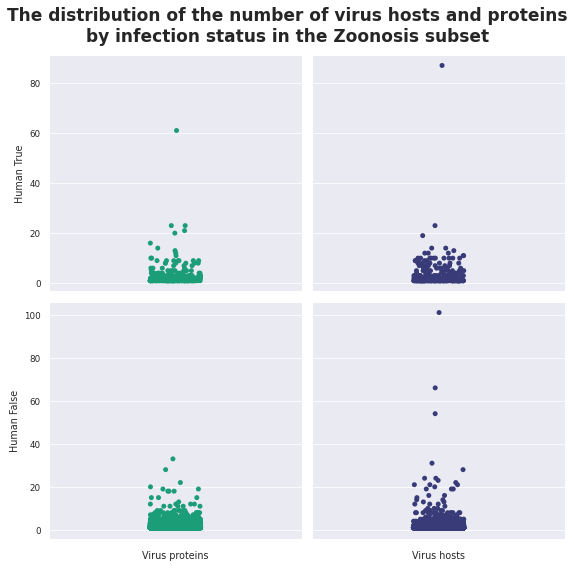

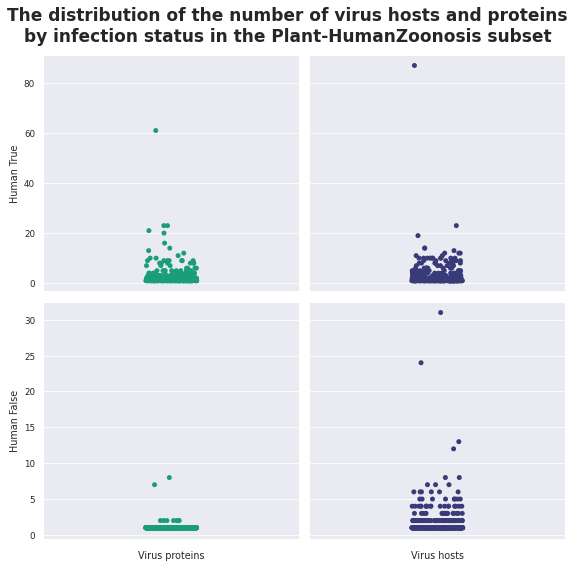

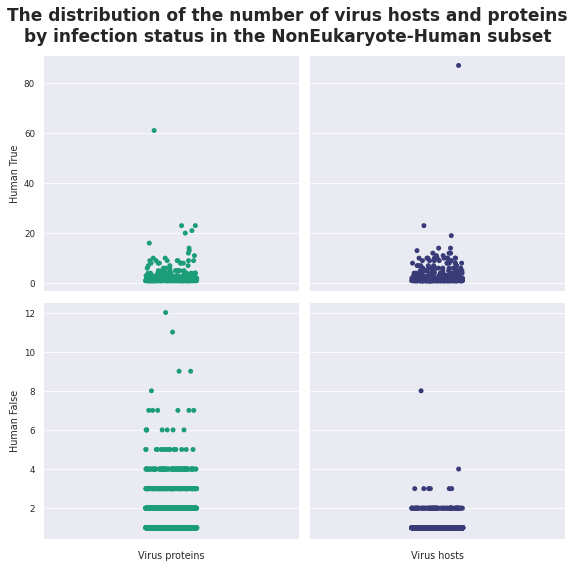

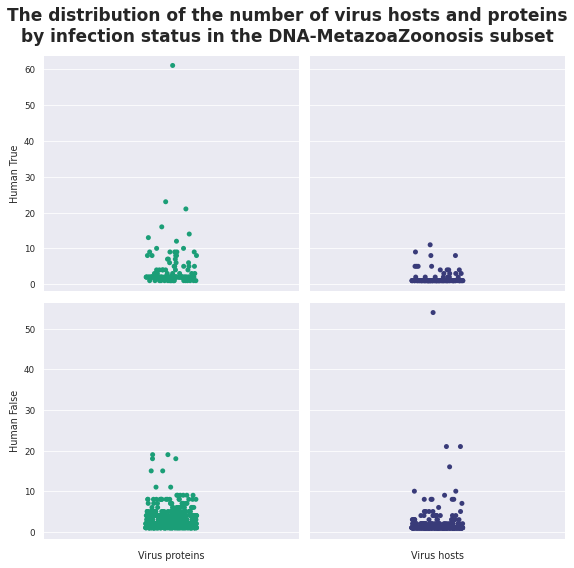

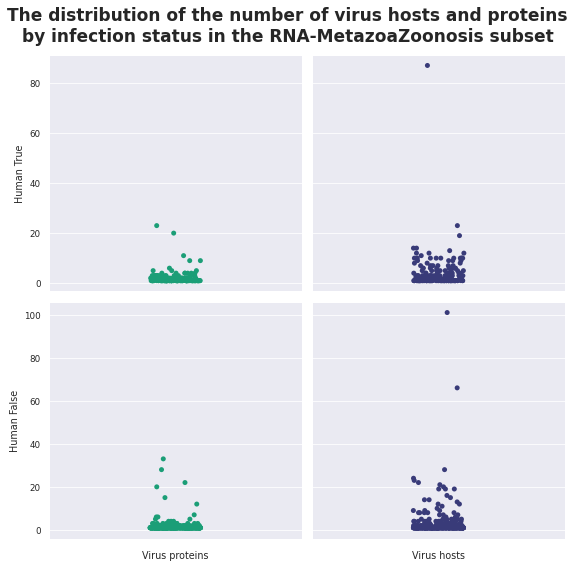

In [197]:
%%time
# plot_swams(NonEukaryote_Human, plot_title)
for df, name in zip(dataframes, files):
    title_plot = f"The distribution of the number of virus hosts and proteins\nby infection status in the {name} subset"
    
    plot_strips(df, title_plot, save=f"{name}_Protein_host_stripplot.png")

In [198]:
full_set = pd.DataFrame()

for df, name in zip(dataframes, files):
    df["Subset"] = name
    full_set = full_set.append(df)

full_set.sample(3)

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence,Subset
7847911,R9TBL0,Fusion glycoprotein F0,574.0,Human orthopneumovirus,11250,Pneumoviridae,Homo sapiens [TaxID: 9606],9606,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...,MetazoaZoonosis
4309477,A0A6C0S4I7,Hemagglutinin,566.0,Influenza A virus,11320,Orthomyxoviridae,Homo sapiens [TaxID: 9606]; Mustela lutreola [...,8830; 9031; 9709; 9796; 9761; 9694; 9666; 9685...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...,Plant-HumanZoonosis
6136436,F8IZG2,Nucleoprotein,498.0,Influenza A virus,11320,Orthomyxoviridae,Homo sapiens [TaxID: 9606]; Mustela lutreola [...,8830; 9031; 9709; 9796; 9761; 9694; 9666; 9685...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...,NonEukaryote-Human


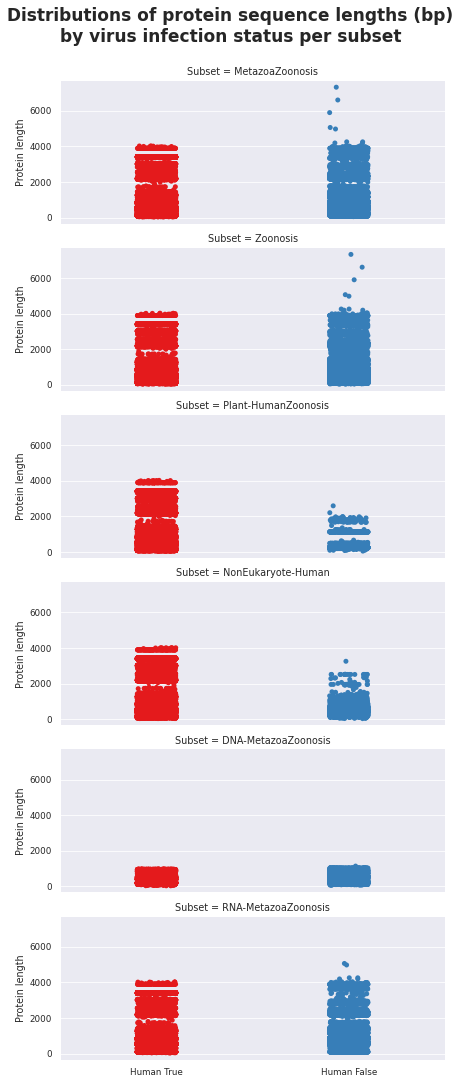

In [199]:
sns.set_theme("paper", "darkgrid", "Set1")

g = sns.catplot(data=full_set,
                x="Infects human", 
                y="Length",
                row="Subset",
                kind="strip",
                aspect=5/2,
                size=2.5
    )

g.fig.suptitle("Distributions of protein sequence lengths (bp)\nby virus infection status per subset",
               y=1.0,
               fontsize=17, fontweight="bold")

# g.fig.set_ylabel("Protein length")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(["Human True", "Human False"])
    _ = axes.set_xlabel("")
    _ = axes.set_ylabel("Protein length")
        


plt.tight_layout()
g.fig.savefig("Subset_length_status.png")

In [200]:
# order = sorted(filter(None, metazoa["Molecule type"].unique().tolist()))
order = ['ssRNA(+)', 'ssRNA(-)', 'ssRNA(+/-)',
         'ssRNA-RT', 'dsRNA', 'ssDNA',
         'ssDNA(-)', 'ssDNA(+/-)', 'dsDNA-RT',
         'dsDNA-RT', 'dsDNA', 'RNA', 'unknown']

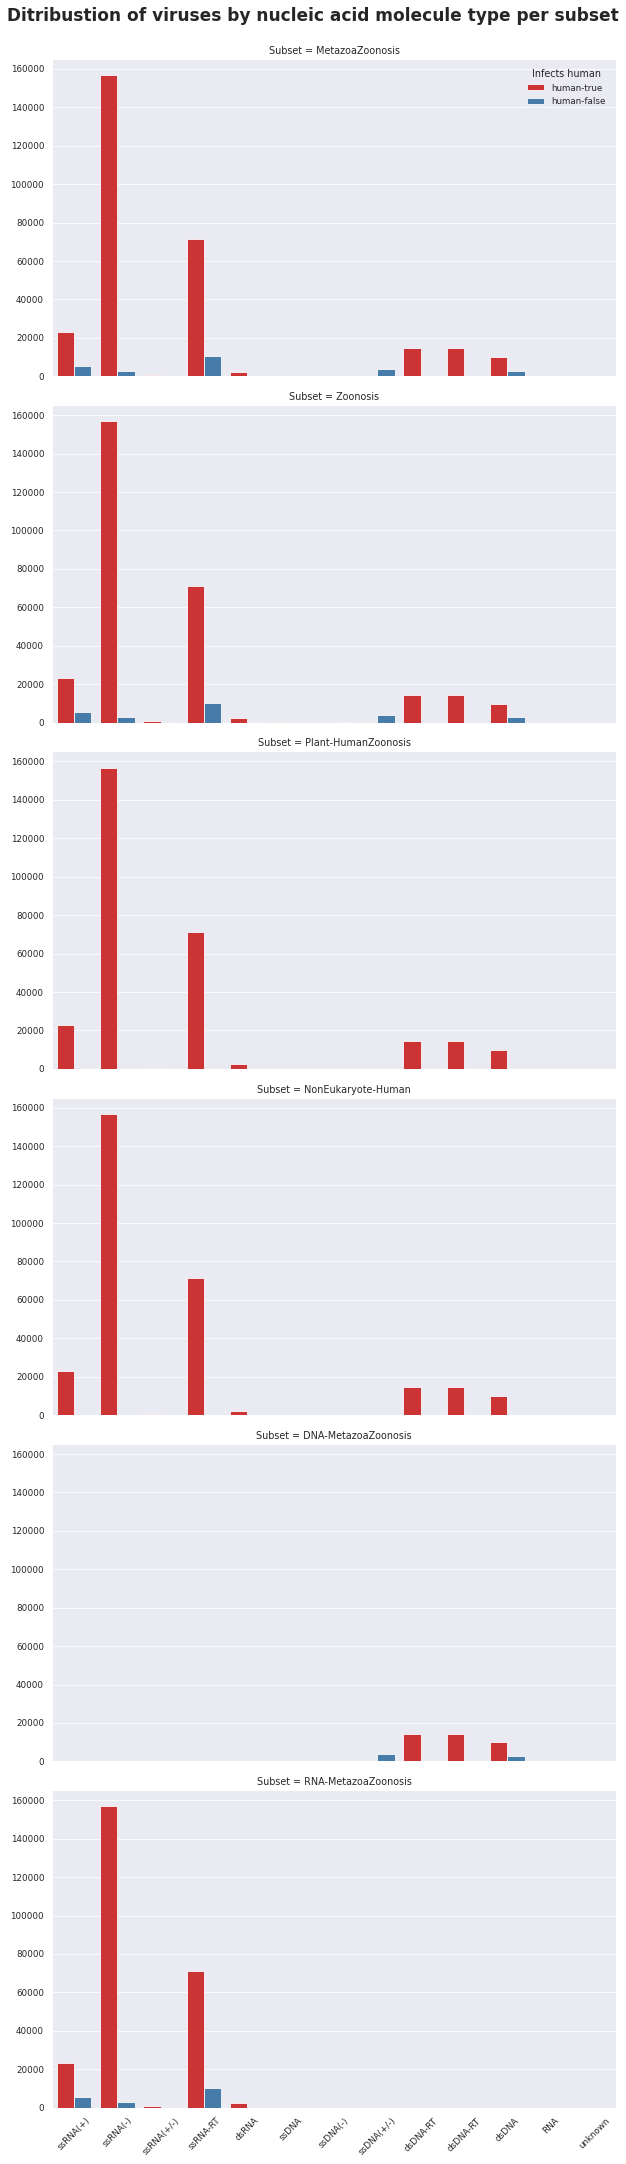

In [214]:
# plt.figure(figsize=(15,8))
sns.set_theme("paper", "darkgrid", "Set1")

g = sns.catplot(data=full_set,
                row="Subset",
                x="Molecule type",
                hue="Infects human",
                kind="count",
                order=order,
                palette="Set1",
                aspect=1.5,
    )

g.fig.suptitle("Ditribustion of viruses by nucleic acid molecule type per subset", fontsize=17, fontweight="bold", y=1.0)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    _ = axes.set_ylabel("")
    _ = axes.set_xlabel("")

sns.move_legend(g, "upper right", bbox_to_anchor=(0.98, 0.975))
plt.tight_layout()
g.fig.savefig("Distribustion_of_virus_nuclear_molecule_types.png")

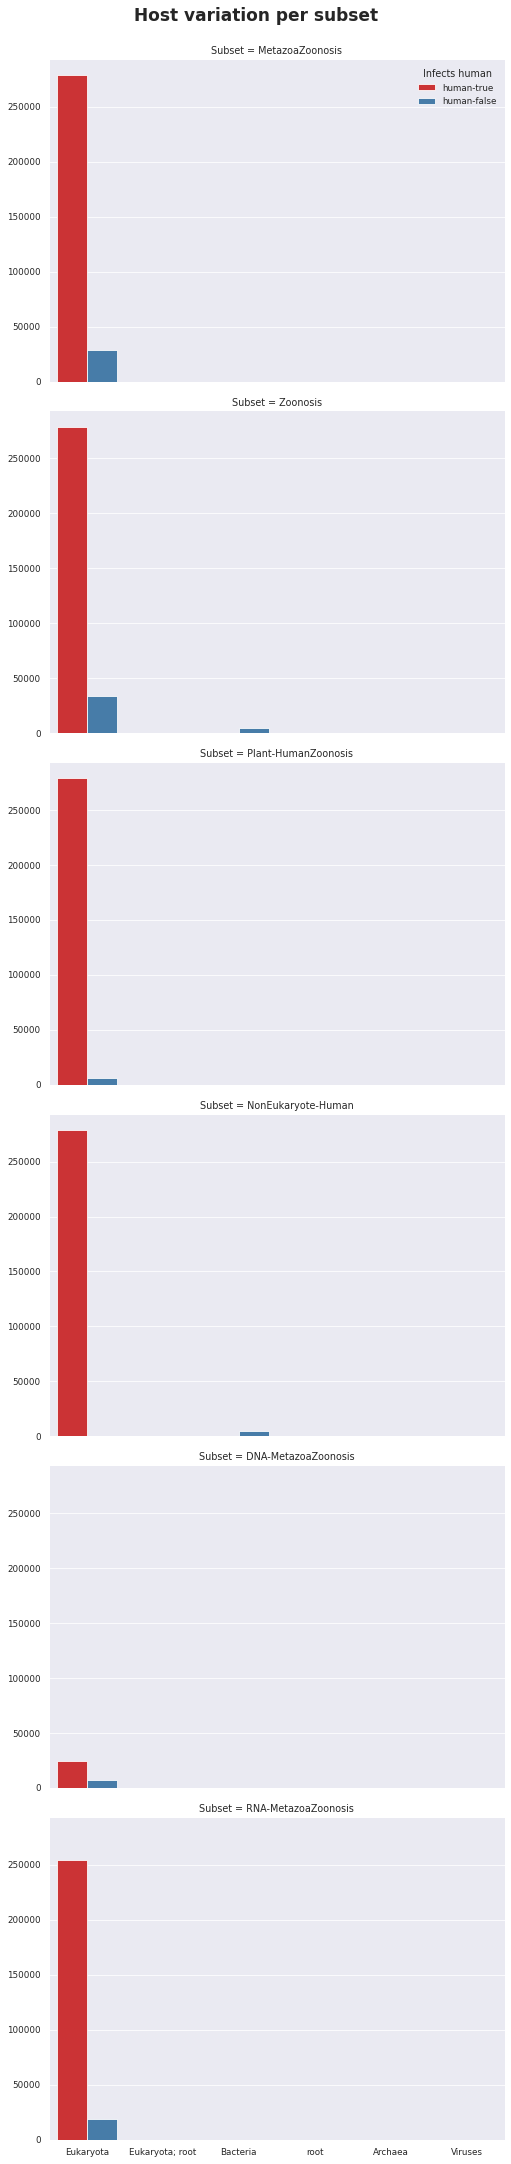

In [213]:
sns.set_theme("paper", "darkgrid", "Set1")

g = sns.catplot(data=full_set,
            row="Subset",
            hue="Infects human", x="Host superkingdom",
            kind="count", palette="Set1", aspect=1.2)

g.fig.suptitle("Host variation per subset", fontsize=17, fontweight="bold", y=1.0)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels())
    _ = axes.set_ylabel("")
    _ = axes.set_xlabel("")
    

sns.move_legend(g, "upper right", bbox_to_anchor=(0.98, 0.975))
plt.tight_layout()
g.fig.savefig("Distribustion_of_virus_nuclear_molecule_types.png")

## Write file sequences to fasta for feature extraction

In [ ]:
## Same order as dataframes
files = [metazoaFile, unfilteredFile, plant_humanFile,
         NonEukaryote_HumanFile, DNA_metazoaFile, RNA_metazoaFile]

dirs = [os.path.join('../data/', fol) for fol in files] # Do not include in script

toSave = list(zip(sampled_dataframes, files, dirs))

<a id="splits"></a>

In [162]:
for dff, file, folder in toSave:
    # Create subdirectories
    os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'train/human-false'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'test/human-false'), exist_ok=True)

    # save dataframes as csv
    dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')
    
    # Split data to train and test data
    train, test = train_test_split(dff, test_size=0.2, random_state=2022) # Will further split 15% of train as validation during training
    # Save test and train sequences
    save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
    save_sequences(test, f'{folder}/test/Sequences')
    
    print('Done with', folder)

Done with ../data/MetazoaZoonosis
Done with ../data/Zoonosis
Done with ../data/Plant-HumanZoonosis
Done with ../data/NonEukaryote-Human
Done with ../data/DNA-MetazoaZoonosis
Done with ../data/RNA-MetazoaZoonosis


In [217]:
# Undersample majority class such that minority class (human-false) is 60% of the majority class (human-true317316)
rus = RandomUnderSampler(sampling_strategy=1, random_state=seed)
sampled_dataframes = []
for dt in dataframes:
    clas = dt['Infects human']
#     print('Dataframe before sampling: ', dt.shape[0])
    dt, _ = rus.fit_resample(dt, clas)
    sampled_dataframes.append(dt)
    check_dist(dt)
#     print('Dataframe after sampling: ', dt.shape[0])

The minoity class is 1.00 of the majority
human-true == 28571 and human false == 28571

The minoity class is 1.00 of the majority
human-true == 38770 and human false == 38770

The minoity class is 1.00 of the majority
human-true == 5748 and human false == 5748

The minoity class is 1.00 of the majority
human-true == 4690 and human false == 4690

The minoity class is 1.00 of the majority
human-true == 7005 and human false == 7005

The minoity class is 1.00 of the majority
human-true == 19020 and human false == 19020



In [218]:
folder = "/scratch3/users/rserage/ZoonosisFull"
dff = unfiltered
file = 'ZoonosisFull'
# Create subdirectories
os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/human-false'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/human-false'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=2022) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')

In [219]:
folder = "/scratch3/users/rserage/ZoonosisOne2One"
dff = unfiltered
file = 'ZoonosisOne2One'
# Create subdirectories
os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/human-false'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/human-false'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=2022) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')

In [220]:
folder = "/scratch3/users/rserage/ZoonosisTwoThirds"
dff = unfiltered
file = 'ZoonosisTwoThirds'
# Create subdirectories
os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/human-false'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/human-false'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=2022) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')